In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import logsumexp

# Evaluating the Parisi formula for a pure p-spin glass

The goal here is to calculate the zero-temperature Parisi constant, and compare it to the maximum satisfying fraction of randomXORSAT instances.

## Using the Parisi formula

Wei-Kuo Chen says:
> I am not aware of numerical simulations for the Parisi constant P(K) for large K. Nevertheless, this constant can be written as the Parisi formula, which is a convex optimization problem (see Theorem 1 in https://arxiv.org/pdf/1606.05335.pdf). With this, it should be fairly easy to run a numerical simulation to approximate P(K) for large K.


Paraphrased from the linked paper:
> We introduce the space $U$ that collects all nonnegative and nondecreasing functions $f$ on $[0,1)$ that are right continuous and satisfy $\int_0^1 f(t)dt < \infty$. Let's say $f$ has $k$ jumps. Then it has value $m_i$ in region $[q_i,q_{i+1})$, given $q_0 = 0$ and $q_{k+1} = 1$, where $m_i$ and $q_i$ are increasing and nonnegative. The distance metric $d$ is the integral of $f$, or equivalently, $d = \sum_{i=0}^k m_i(q_{i+1} - q_i)$.

$P(f) = \Psi_f(0, h) - 0.5 \int_0^1 t \xi^{''}(t)f(t) dt$

$\xi(s) =\sum_{p\ge 2} c_p^2 s^p$ Where the $c_p$'s are the mixing constants (mixed vs pure spin glasses).

$\partial_t \Psi_f(t,x) = -0.5\xi^{''}(t) 
\Big(
\partial_x^2 \Psi_f(t,x) + f(t) (\partial_x \Psi_f(t,x))^2
\Big)$

With boundary condition: $\Psi_f(1,x) = |x|$.

This can be solved recursively, by using the transformation $f(t) \Psi = \log \Phi$ for a piecewise, continuous function $f$.

This is the coefficient $a_{\ell} = \sqrt{ \xi^{'}(q_{\ell+1}) - \xi^{'}(q_{l}) }$

In [2]:
global k, xi, xiprime, xiprimeprime, grid, INPS, PDF_INPS

In [3]:
def a(qs, l):
    return (xiprime(qs[l+1]) - xiprime(qs[l]))**0.5

Let $\Psi_{k+1}(x) = abs(x)$.

For $1\le \ell \le k$, let $Exp(m_{\ell} \Psi_{\ell}(x)) = \mathbb{E}[Exp(m_{\ell} \Psi_{\ell+1}(x + a_{\ell} z) ]$, for standard Gaussian variable $z$.

Let $\Psi_0(x) = \mathbb{E}[\Psi_{\ell+1}(x + a_{0} z)]$, since I let $m_0 = 0$.

In [4]:
def psi0(qs, ms):
    a_s = np.array([a(qs, l) for l in range(len(qs)-1)])
    start = 0
    for i in range(len(grid)):
        start += a_s[i]*grid[i]
    start =  np.abs(start)
    # 1 to k
    for i in list(range(1, k+1))[::-1]:
        start = logsumexp(ms[i]*start, b=PDF_INPS, axis=i)/ms[i]
    # 0
    start = np.sum(PDF_INPS*start, axis=0)
    return start

The penalty term in the operator is $0.5 \int_0^1 f(t)  t \xi^{''}(t) dt = 0.5 \sum_{i=0}^k \int_{q_i}^{q_{i+1}} m_i t \xi^{''}(t) dt$

In [5]:
def penalty(qs, ms):
    out = 0
    for i in range(k+1):
        integral = quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]
        out += ms[i] * integral
    return 0.5 * out

This tests the ground state energy of inputs **m**, **q**:

In [6]:
# the input here is a list of "adjustments" 
# (m_1, m_2-m_1, ...,m_k-m_{k-1}, q_1, q_2-q_1,...,q_k-q_{k-1})
def test(inp):
    assert len(inp) == 2*k
    inp_qs,inp_ms= inp[:k],inp[k:]

    # if bad input, return a large number
    if np.any(np.array(inp) < 0) or sum(inp_ms) > 2 or sum(inp_qs) > 1:
        return 10000

    qs = np.array([0,*[sum(inp_qs[:i+1]) for i in range(k)],1])
    ms = np.array([0,*[sum(inp_ms[:i+1]) for i in range(k)]])
    output =  psi0(qs, ms) - penalty(qs, ms)
    return output

## Evaluating the Parisi formula

kXOR:
p: 2 1.5304952601931465
p: 3 1.6270851336785448
p: 4 1.65095677619676
p: 5 1.6592661332722143
p: 6 1.6625547616682574
p: 7 1.6639532758761009
p: 8 1.6645745603634108
p: 9 1.6648583348427453
p: 10 1.6649903332259495
p: 11 1.6650524923720855
p: 12 1.6650820151058454
p: 13 1.6650961235764488
p: 14 1.665102896806678
p: 15 1.6651061600814057
p: 16 1.665107736774127
p: 17 1.6651085003665695
p: 18 1.6651088709123805
p: 19 1.6651090510362145
p: 20 1.6651091387280008
p: 21 1.6651091814776287
p: 22 1.665109202343281
p: 23 1.6651092125388018
p: 24 1.6651092175255044
p: 25 1.6651092199668405
p: 26 1.6651092211629788
p: 27 1.6651092217495354
p: 28 1.6651092220373407
p: 29 1.6651092221786712
p: 30 1.6651092222481054
p: 31 1.665109222282279
p: 32 1.6651092222990371
p: 33 1.6651092223073007
p: 34 1.6651092223113686


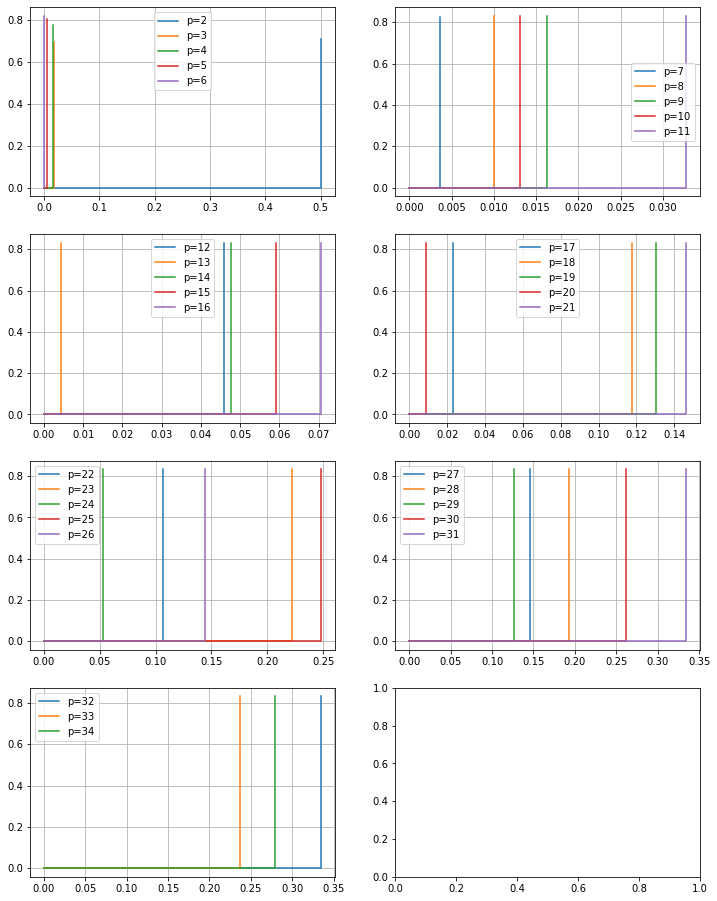

In [7]:
print("kXOR:")

# k is number of jumps
k=1
# if this range is too small, it fails at higher k
INPS = np.linspace(-30,30, 1000)
PDF_INPS = stats.norm.pdf(INPS)
PDF_INPS = PDF_INPS/np.sum(PDF_INPS)
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)
grid = np.meshgrid(*[INPS]*(k+1), indexing='ij')

# pure p-spin model; p=2 is SK model
ps = range(2, 35)
# if C_psq is too low, my convergence is not very good.
C_psq = 2

num_vert_plots = int(np.ceil(len(ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))
outs = []
for idx in range(len(ps)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: x**P * C_psq
    xiprime = lambda x: P * (x**(P-1)) * C_psq
    xiprimeprime = lambda x: P * (P-1) * (x**(P-2)) * C_psq
    
    # find best function from minimizer
    best = None
    for _ in range(1):
        opt = minimize(test, 
                       [np.random.random()/k for _ in range(2*k)], 
                       method='Powell', 
                       options={"xtol": 1e-10, "ftol":1e-14}
                      )
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = np.array([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
#     print("qs:", qs)
#     print("ms:", ms)
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()
outs = np.array(outs)

I notice that the locations of the symmetry breaking points are often at very low values.  This may be related to the Auffinger Chen Zeng result that perturbing a solution to this variational near $1$ will reduce the energy. So perhaps perturbations very close to $0$ can also reduce the energy: https://doi.org/10.1002/cpa.21886

## Finding the large-p limit

Let's look at the constants after dividing out by $c_p$:

In [8]:
outs_scaled = np.array(outs)* C_psq**-0.5

In [9]:
for p, x in zip(ps, outs_scaled):
    print(p, x)

2 1.0822235770564435
3 1.1505229315919192
4 1.1674027318946105
5 1.1732783346299644
6 1.1756037460696092
7 1.1765926449495612
8 1.1770319594235839
9 1.177232618282249
10 1.1773259552341184
11 1.177369908387864
12 1.1773907841131048
13 1.1774007603083405
14 1.1774055497053662
15 1.177407857189055
16 1.17740897207917
17 1.1774095120205643
18 1.1774097740360199
19 1.1774099014028043
20 1.177409963410261
21 1.177409993638813
22 1.1774100083930572
23 1.177410015602379
24 1.1774100191285104
25 1.1774100208547955
26 1.1774100217005932
27 1.1774100221153512
28 1.1774100223188604
29 1.177410022418796
30 1.1774100224678934
31 1.1774100224920578
32 1.1774100225039077
33 1.1774100225097508
34 1.1774100225126274


In [10]:
guess = (2*np.log(2))**0.5

In [11]:
print(guess)

1.1774100225154747


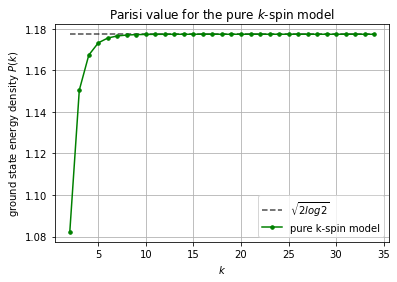

In [12]:
plt.plot(ps, [guess]*len(ps), 'b--', 
         color='black', label="$\sqrt{2 log 2}$", alpha=0.7)
plt.plot(ps, outs_scaled, 'g.-', ms=7,label="pure k-spin model")
plt.xlabel("$k$")
plt.ylabel("ground state energy density $P(k)$")
plt.title("Parisi value for the pure $k$-spin model")
plt.grid()
plt.legend()
plt.savefig('images/parisi_value.png', dpi=300)

## Relationship with $c_{p}$

I ran the above several times for different $c_p$. 
The asymptotic value seems to depend on the constant I use. If $c_p^2 < 2 log(2)$, The energy is $log(2) + c_p^2 / 2$. Otherwise, the energy is $\sqrt{ 2 c_p^2 log(2)}$.

Text(0, 0.5, '$energy / C_p$')

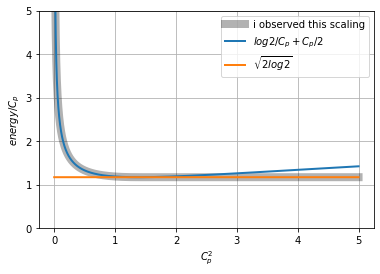

In [13]:
# this is what I observed after running for many different c_p^2
inps = np.linspace(1e-10, 5, 100000)
f1 = lambda x: x**-0.5 * (np.log(2) + x/2)
f2 = lambda x: x**-0.5 * (2 * x * np.log(2))**0.5

plt.plot(inps, [f1(i) if i < 2*np.log(2) else f2(i) for i in inps], 
         label='i observed this scaling',
         linewidth=8, alpha=0.3, color='black')
plt.plot(inps, f1(inps), label='$log 2/C_p +C_p/2$', linewidth=2)
plt.plot(inps, f2(inps), label='$\sqrt{2 log 2}$', linewidth=2)
# plt.plot(inps, inps**0.5, label='sqrt(x) (expected scaling)', linewidth=2)
plt.legend()
plt.grid()
plt.ylim(0,5)
plt.xlabel('$C_p^2$')
plt.ylabel("$energy / C_p$")

The minimum energy should be proportional to $c_p$. I think this means the limit of $P(p)$ is in fact $\sqrt{2 log 2}$.

This ended up being true, because of the relationship to the random energy model.

## Comparison with Montanari for Max 2XOR, Max 3XOR

This also roughly matches the calculation in https://arxiv.org/pdf/2009.11481.pdf that does Max 2XOR and Max 3XOR. They get
$$
e_2 = 0.763168\pm 0.000002
$$
and 
$$
e_3 = 0.8132\pm 0.0001
$$

Where $e_2$ uses $\xi(s) = s^2/2$ and $e_3$ uses $\xi(s) = s^3/2$.

In [14]:
for p, o in list(zip(ps, outs_scaled))[:2]:
    print("my result, p:", p, "e_p:", o * 2**-0.5)

my result, p: 2 e_p: 0.7652476300965734
my result, p: 3 e_p: 0.8135425668392725


The agreement gives me confidence that my approach is correct.

One way to improve my precision is to explicitly solve for the derivative, and use it in the optimization procedure (as the Montanari paper does).

## Using the Parisi constants in Sen's Max XOR upper bound

I insert these values for Subhabrata Sen's bounds for Max XOR on hypergraphs, as listed here: https://doi.org/10.1002/rsa.20774

The satisfying fraction for Max CUT on p-uniform hypergraphs is to first order in D: $\frac{1}{2}+ \frac{P_p \sqrt{p}}{2}\frac{1}{\sqrt{D}}$

This makes the satisfying fraction $\frac{1}{2} + \frac{C_p}{\sqrt{D}}$, where $C_p$ is listed below:

In [15]:
for p, x in zip(ps, outs_scaled):
    print(p, x * p**0.5 / 2)

2 0.7652476300965734
3 0.9963820863951478
4 1.1674027318946105
5 1.311765056380173
6 1.4398146587874936
7 1.5564857664821279
8 1.664574560363411
9 1.7658489274233735
10 1.8615157834866252
11 1.9524471127888277
12 2.0393006584472566
13 2.122589406531004
14 2.202724086141858
15 2.2800405112934854
16 2.35481794415834
17 2.4272918913338666
18 2.4976633063685707
19 2.5661053876695066
20 2.632768715570884
21 2.697785209923667
22 2.761271229570316
23 2.823330034345005
24 2.8840537649054316
25 2.9435250521369887
26 3.0018183380755143
27 3.0590009694668754
28 3.1151341102107137
29 3.170273508148574
30 3.2244701436916485
31 3.2777707818350867
32 3.3302184445980747
33 3.381852817484507
34 3.4327106008899264


Because of the limit, we expect a large $p$XORSAT problem to have satisfying fraction at most

$$\frac{1}{2} + \frac{\sqrt{2 log 2}}{2} \sqrt{\frac{p}{D}} = \frac{1}{2} + \sqrt{\frac{p log 2}{2}} \frac{1}{\sqrt{D}} \approx \frac{1}{2} + 0.58871\sqrt{\frac{p}{D}}$$

## Bonus: Evaluating the $p$-SAT approximations

A similar formula to Sen has been done by Panchenko for $p$-SAT: https://arxiv.org/pdf/1608.06256.pdf

Given $N$ variables and $\alpha N$ clauses, the satisfying fraction is 
$$1-\frac{1}{2^p} + \frac{B_p}{2^p}\frac{1}{\sqrt{\alpha}}$$

Where $B_p$ is the limit of a Parisi formula with $\xi(x) = (1+x)^p - 1$.

kSAT:
p: 3 1.5723564301893096
p: 4 2.6563377699189004
p: 5 4.135375546995508
p: 6 6.1765044858839735
p: 7 9.014787979614526
p: 8 12.984351273487327
p: 9 18.558871882750708
CPU times: user 34.5 s, sys: 7.89 s, total: 42.4 s
Wall time: 42.3 s


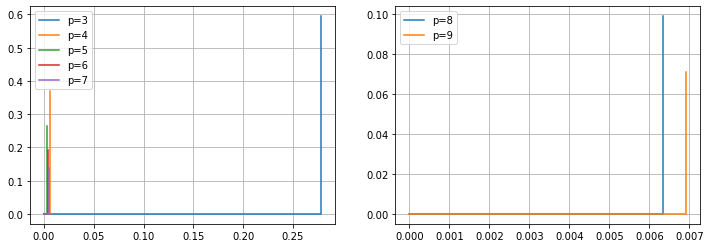

In [16]:
%%time
print("kSAT:")

ksat_ps = range(3, 10)

# CONST_SQ may affect my convergence.
CONST_SQ = 0.5

num_vert_plots = int(np.ceil(len(ksat_ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))
outs = []
for idx in range(len(ksat_ps)):
    P = ksat_ps[idx]
    if idx % 5 == 0:
        ax = axs[(idx % 10) //5] #axs[idx // 10, (idx % 10)//5]
        ax.grid()
    # should xi be different by 1/2 ? I've seen it both ways.
    xi = lambda x: CONST_SQ* (-1 + (1+x)**P)
    xiprime = lambda x: CONST_SQ* P * ((1+x)**(P-1))
    xiprimeprime = lambda x:CONST_SQ* P * (P-1) * ((1+x)**(P-2))
    
    # find best function from minimizer
    best = None
    for _ in range(1):
        opt = minimize(test, 
                       [np.random.random()/k for _ in range(2*k)],
                       method='Powell', 
                       options={"ftol":1e-14}
                      )
        if not best or best.fun > opt.fun:
            best = opt
    print("p:", P, best.fun)
    outs.append(best.fun)

    qs = np.array([0,*[sum(best.x[:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(best.x[k:][:i+1]) for i in range(k)]])
#     print("qs:", qs)
#     print("ms:", ms)
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()
outs = np.array(outs)

The constants after reducing by CONST_SQ (to help with convergence):

In [17]:
ksats_scaled = outs * CONST_SQ**-0.5

In [18]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o)

3 2.2236477884582664
4 3.756628900463211
5 5.848304184067104
6 8.734896411995377
7 12.748835422688817
8 18.362645669582147
9 26.24620831893075


I calculate $C$, where the satisfying fraction is $1-1/2^p + C/\sqrt{\alpha}$:

In [19]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o*2**(-p))

3 0.2779559735572833
4 0.2347893062789507
5 0.182759505752097
6 0.13648275643742777
7 0.09960027673975638
8 0.07172908464680526
9 0.051262125622911624


It would be nice to get a confirmation on this constant, but I haven't seen it calculated anywhere.